In [2]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [3]:
#importing our cancer dataset
glioma_data = pd.read_csv('TCGA_InfoWithGrade.csv')
print(glioma_data.shape)


(839, 24)


In [4]:
X = glioma_data.drop("Grade", axis=1)
y = glioma_data["Grade"]

drop_list2 = ['Gender','Race', 'PIK3CA', 'NF1', 'BCOR', 'CSMD3', 'SMARCA4', 'FAT4']
X2 = X.drop(drop_list2,axis = 1 )

print(X2.shape)
print(y.shape)

(839, 15)
(839,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(671, 15) (671,)
(168, 15) (168,)


In [6]:
#Feature Scaling

from sklearn.preprocessing import StandardScaler

sc_scaler = StandardScaler()

X_train = sc_scaler.fit_transform(X_train)
X_test = sc_scaler.transform(X_test)

print(X_train.shape)

(671, 15)


In [7]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

**INDIVIDUAL MODELS**

**1. GaussianProcessClassifier**

In [8]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score

# Create a Gaussian Process Classifier with an RBF kernel
kernel = RBF(1.0)  # Radial basis function (RBF) kernel
gpc = GaussianProcessClassifier(kernel= 1**2 * RBF(length_scale=1), n_restarts_optimizer= 0)

# Fit the classifier to the training data
gpc.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = gpc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9166666666666666


**4. DecisionTreeClassifier**

In [9]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_leaf=2, min_impurity_decrease=0.1)
# Train the classifier on the training data
dtree.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = dtree.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9047619047619048


**5. GaussianNaiveBayes**

In [10]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(var_smoothing=0.01)

# Train the classifier on the training data
gnb.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = gnb.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9226190476190477


**6. XGBoost**

In [11]:
#XGBClassifier
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(gamma= 0, learning_rate= 0.2, max_depth= 3, n_estimators= 50)
xgb_clf.fit(X_train_resampled, y_train_resampled)
print(xgb_clf.score(X_test, y_test))

0.9166666666666666


**7. GradientBoostingClassifier**

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_clf = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 5, min_samples_leaf= 1, min_samples_split= 10, n_estimators= 50, subsample= 0.8)
gbc_clf.fit(X_train_resampled, y_train_resampled)
# Make predictions on the test set
y_pred = gbc_clf.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9166666666666666


Ensemble methods


VotingClassifier


In [14]:
from sklearn.ensemble import VotingClassifier

from itertools import combinations
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve)
estimators = [("GNB", gnb), ("DT", dtree), ("XGB", xgb_clf), ("GPC", gpc), ("GBC", gbc_clf)]

vot_classifiers = []
for n in range(3, 6):
    for subset in combinations(estimators, n):
        vot_classifier = VotingClassifier(estimators=list(subset), voting='soft')
        vot_classifiers.append(vot_classifier)

results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results_dff = pd.DataFrame(columns=['Classifier', 'TP', 'FP', 'FN', 'TN'])


for vc in vot_classifiers:
    vc.fit(X_train_resampled, y_train_resampled)
    y_pred = vc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    classifier_name = [name for name, _ in vc.estimators]
    clasf_names_str = ', '.join(classifier_name)
    cm = confusion_matrix(y_test, y_pred)
    tp, fp, fn, tn = cm.ravel()
    results_df = results_df.append({'Classifier': clasf_names_str, 'Accuracy': accuracy,
                                    'Precision': precision, 'Recall': recall, 'F1 Score': f1},
                                   ignore_index=True)
    results_dff = results_dff.append({'Classifier': clasf_names_str, 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn},ignore_index=True)


In [15]:
combo = results_df.style.format(precision=3)
def highlight_max(s):
    is_max = s == s.max()
    return ['background: lightgreen' if cell else '' for cell in is_max]
combo.apply(highlight_max)


,Classifier,Accuracy,Precision,Recall,F1 Score
0,"GNB, DT, XGB",0.923,0.863,0.972,0.914
1,"GNB, DT, GPC",0.917,0.852,0.972,0.908
2,"GNB, DT, GBC",0.917,0.852,0.972,0.908
3,"GNB, XGB, GPC",0.923,0.863,0.972,0.914
4,"GNB, XGB, GBC",0.923,0.863,0.972,0.914
5,"GNB, GPC, GBC",0.923,0.863,0.972,0.914
6,"DT, XGB, GPC",0.917,0.852,0.972,0.908
7,"DT, XGB, GBC",0.917,0.852,0.972,0.908
8,"DT, GPC, GBC",0.917,0.852,0.972,0.908
9,"XGB, GPC, GBC",0.917,0.852,0.972,0.908


In [16]:
results_dff

,Classifier,TP,FP,FN,TN
0,"GNB, DT, XGB",86,11,2,69
1,"GNB, DT, GPC",85,12,2,69
2,"GNB, DT, GBC",85,12,2,69
3,"GNB, XGB, GPC",86,11,2,69
4,"GNB, XGB, GBC",86,11,2,69
5,"GNB, GPC, GBC",86,11,2,69
6,"DT, XGB, GPC",85,12,2,69
7,"DT, XGB, GBC",85,12,2,69
8,"DT, GPC, GBC",85,12,2,69
9,"XGB, GPC, GBC",85,12,2,69


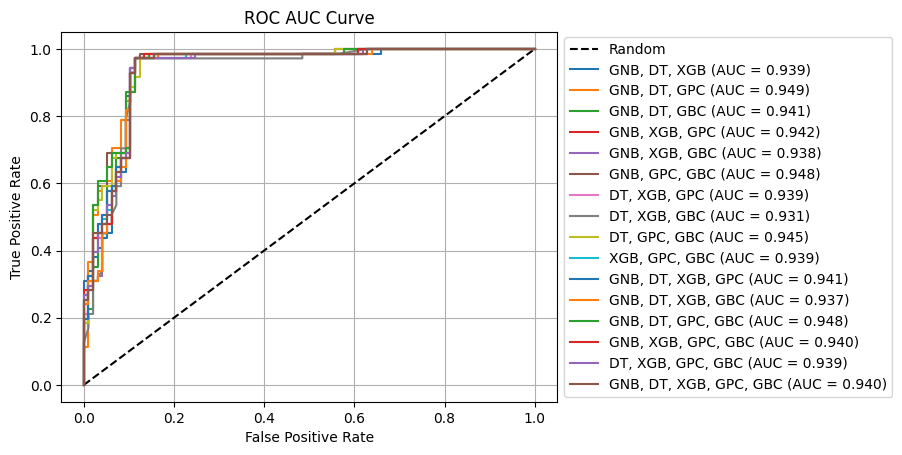

In [17]:
plt.plot([0, 1], [0, 1], 'k--', label='Random')

for vc in vot_classifiers:
    vc.fit(X_train_resampled, y_train_resampled)
    y_pred_proba = vc.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    classifier_name = [name for name, _ in vc.estimators]
    clasf_names_str = ', '.join(classifier_name)
    plt.plot(fpr, tpr, label=f'{clasf_names_str} (AUC = {roc_auc:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

**STACKING ENSEMBLE**

In [18]:
from sklearn.ensemble import StackingClassifier

estimators = [("GNB", gnb), ("DT", dtree), ("XGB", xgb_clf), ("GPC", gpc), ("GBC", gbc_clf)]
stk_classifiers = []
for n in range(3, 6):
    for subset in combinations(estimators, n):
        stk_classifier = StackingClassifier(estimators=list(subset), final_estimator=gnb)
        stk_classifiers.append(stk_classifier)

stk_results = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
stk_resultss = pd.DataFrame(columns=['Classifier', 'TP', 'FP', 'FN', 'TN'])


for stk in stk_classifiers:
    stk.fit(X_train_resampled, y_train_resampled)
    y_pred = stk.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    classifier_name = [name for name, _ in stk.estimators]
    clasf_names_str = ', '.join(classifier_name)
    cm = confusion_matrix(y_test, y_pred)
    tp, fp, fn, tn = cm.ravel()
    stk_results = stk_results.append({'Classifier': clasf_names_str, 'Accuracy': accuracy,
                                    'Precision': precision, 'Recall': recall, 'F1 Score': f1},
                                   ignore_index=True)
    stk_resultss = stk_resultss.append({'Classifier': clasf_names_str, 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn},ignore_index=True)

In [19]:
stk_combo = stk_results.style.format(precision=3)
def highlight_max(s):
    is_max = s == s.max()
    return ['background: lightgreen' if cell else '' for cell in is_max]
stk_combo.apply(highlight_max)


,Classifier,Accuracy,Precision,Recall,F1 Score
0,"GNB, DT, XGB",0.923,0.863,0.972,0.914
1,"GNB, DT, GPC",0.917,0.852,0.972,0.908
2,"GNB, DT, GBC",0.917,0.852,0.972,0.908
3,"GNB, XGB, GPC",0.923,0.863,0.972,0.914
4,"GNB, XGB, GBC",0.923,0.863,0.972,0.914
5,"GNB, GPC, GBC",0.923,0.863,0.972,0.914
6,"DT, XGB, GPC",0.917,0.852,0.972,0.908
7,"DT, XGB, GBC",0.917,0.852,0.972,0.908
8,"DT, GPC, GBC",0.917,0.852,0.972,0.908
9,"XGB, GPC, GBC",0.917,0.852,0.972,0.908


In [20]:
stk_resultss


,Classifier,TP,FP,FN,TN
0,"GNB, DT, XGB",86,11,2,69
1,"GNB, DT, GPC",85,12,2,69
2,"GNB, DT, GBC",85,12,2,69
3,"GNB, XGB, GPC",86,11,2,69
4,"GNB, XGB, GBC",86,11,2,69
5,"GNB, GPC, GBC",86,11,2,69
6,"DT, XGB, GPC",85,12,2,69
7,"DT, XGB, GBC",85,12,2,69
8,"DT, GPC, GBC",85,12,2,69
9,"XGB, GPC, GBC",85,12,2,69


In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Define the base classifier
base_classifiers = RandomForestClassifier()

# Create the bagging classifier
bagging_clf = BaggingClassifier(base_estimator=base_classifiers, n_estimators=10, random_state=42)

# Train the bagging classifier on the training data
bagging_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = bagging_clf.predict(X_test)

# Evaluate the ensemble's performance
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Accuracy:", accuracy)


Ensemble Accuracy: 0.8869047619047619


In [22]:
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# Define the base classifier
base_classifier = RandomForestClassifier()


# Create the AdaBoost classifier
adaboost_clf = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

# Train the AdaBoost classifier on the training data
adaboost_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = adaboost_clf.predict(X_test)

# Evaluate the ensemble's performance
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Accuracy:", accuracy)

Ensemble Accuracy: 0.8214285714285714
